# Trabalho Prático 1 - ALG2
**Aluno:** César de Paula Morais - 2021031521

**Aluno:** Matheus Grandinetti Barbosa Lima - 2021067496

**Aluno:** Pedro Henrique Fernandes Baptista - 2021031610

## Introdução

<p style="text-align: justify;">Este notebook lida com a problemática da classificação de pontos inseridos em modelo previamente treinado. O treinamento acontece por meio da criação de envoltórias convexas, bem como a verificação da separabilidade linear entre duas envoltórias e a identificação de um ponto médio entre essas, de forma a obter um modelo de classificação que pode ser usado em datasets diversos. Para melhor explicação dos algoritmos e dos passos necessários para a criação dos modelos, o trabalho será divido em 5 principais partes:</p>

*   Primitivas
*   Envoltória convexa
*   Separabilidade linear
*   Ponto médio entre envoltórias
*   Criação e análise dos modelos







## Imports ##

In [220]:
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
from sklearn import datasets, metrics
from sklearn.decomposition import PCA
import numpy as np

## Primitivas

As seguintes classes básicas foram criadas como forma de abstrair conceitos geométricos importantes para o experimento.

**Ponto:**

In [221]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    # Id means to which group the point belongs
    def set_id(self, id):
        self.id = id

**Segmento:**

In [222]:
class Segment:
    def __init__(self, smaller: Point, greater: Point):
        self.smaller = smaller
        self.greater = greater

Além disso, foram utilizadas algumas funções auxiliares, agrupados na classe *Tools*:

In [223]:
class Tools:
    @classmethod
    def do_segments_intercept(cls, s1: Segment, s2: Segment):
        if s1.smaller == s2.smaller or s1.smaller == s1.greater or s1.smaller == s2.greater or s1.smaller == s2.greater:
            return True

        o1 = cls.find_orientation(s1.smaller, s1.greater, s2.smaller)
        o2 = cls.find_orientation(s1.smaller, s1.greater, s2.greater)
        o3 = cls.find_orientation(s2.smaller, s2.greater, s1.smaller)
        o4 = cls.find_orientation(s2.smaller, s2.greater, s1.greater)

        # General case
        if o1 != o2 and o3 != o4:
            return True

        # Special cases (colinear or one segment's endpoint on the other segment)
        if (
            o1 == 0 and cls.on_segment(s1.smaller, s2.smaller, s1.greater)
            or o2 == 0 and cls.on_segment(s1.smaller, s2.greater, s1.greater)
            or o3 == 0 and cls.on_segment(s2.smaller, s1.smaller, s2.greater)
            or o4 == 0 and cls.on_segment(s2.smaller, s1.greater, s2.greater)
        ):
            return True
        return False

    @classmethod
    # Check if point q lies on line segment pr
    def on_segment(cls, p, q, r):
        return (
            (q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x))
            and (q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y))
        )

    def find_orientation(p1: Point, p2: Point, p3: Point):
        cross_product = (p2.y - p1.y) * (p3.x - p2.x) - (p2.x - p1.x) * (p3.y - p2.y)

        if cross_product == 0:
            return 0
        elif cross_product > 0:
            return 1
        else:
            return -1

    def point_to_list(set: list[Point]):
      x_list = [point.x for point in set]
      y_list = [point.y for point in set]

      return (x_list, y_list)

    def get_point_distance(p1: Point, p2: Point):
        return abs(pow((pow((p1.x - p2.x), 2) + pow((p1.y - p2.y), 2)), 0.5))
    
    @classmethod
    def points_to_np_array(cls, points :list[Point]):
        point_arrays = []

        for p in points:
            np_p = np.array([p.x, p.y])
            point_arrays.append(np_p)

        if point_arrays:  # Check if there are any point arrays
            array = np.vstack(point_arrays)
        else:
            array = np.array([])

        return array
    
    @classmethod
    def pointsort(cls, array):
        cls._point_sort(array, 0, len(array)-1)
        
    @classmethod
    def _point_sort(cls, array, low, high):
        if low < high:
            pi = cls._partition(array, low, high)
            cls._point_sort(array, low, pi-1)
            cls._point_sort(array, pi+1, high)
    
    @classmethod
    def _partition(cls, array, low, high):
        # Pivot is last element
        pivot = array[high]
        p = low-1
        
        for j in range(low,high):
            if array[j].x < pivot.x or (array[j].x == pivot.x and array[j].y < pivot.y):
                p = p + 1
                (array[p], array[j]) = (array[j], array[p])
                
        (array[p + 1], array[high]) = (array[high], array[p + 1])
        
        return p + 1
    
    def point_to_list(set: [Point]):
      x_list = [point.x for point in set]
      y_list = [point.y for point in set]

      return (x_list, y_list)
    
    def point_inside_hull(point: Point, point_list: list[Point]):
        crossings = 0

        point_list.append(point_list[0])

        for iter in range(0, len(point_list)-1):
            slope = (point_list[iter+1].y - point_list[iter].y) / (point_list[iter+1].x - point_list[iter].x + 0.000000001)
            cond1 = (point_list[iter].x <= point.x) and (point.x < point_list[iter+1].x)
            cond2 = (point_list[iter+1].x <= point.x) and (point.x < point_list[iter].x)
            above = (point.y < slope * (point.x - point_list[iter].x) + point_list[iter].y)
            
            if((cond1 or cond2) and above): crossings +=1
        return (crossings % 2 != 0)

## Envoltória Convexa

<p style="text-align: justify;">Para resolver a problemática da envoltória convexa, utilizamos o algoritmo de Jarvis, conhecido também como Gift Wrap. Funções auxiliares foram criadas com o objetivo de facilitar a manutenção e visualização dos resultados obtidos dentro da classe ConvexHull.</p>

In [224]:
class ConvexHull:
    def __init__(self, point_set):
        self.point_set = point_set
        self.hull = []
        self.tools = Tools

    def find_point_index(self, p):
        index = 0

        for point in self.point_set:
            if p.x == point.x and p.y == point.y:
                return index
            index += 1

    def find_ancor(self):
        ancor = self.point_set[0]

        for point in self.point_set:
            if point.x < ancor.x:
                ancor = point

        return ancor

    def find_next_ancor(self, p, q):
        for point in self.point_set:
            if self.tools.find_orientation(p,q,point) == 1:
                q = point
        return q

    def find_convex_hull(self):
        set_size = len(self.point_set)

        ancor = self.find_ancor()
        self.hull.append(ancor)
        next = self.point_set[(self.find_point_index(ancor)+1)%set_size]

        current = self.find_next_ancor(ancor, next)


        while True:
            self.hull.append(current)
            next = self.point_set[(self.find_point_index(current)+1)%set_size]
            current = self.find_next_ancor(current, next)

            if current.x == self.hull[0].x and current.y == self.hull[0].y:
                break

<p style="text-align: justify;">Para verificar a corretude do código, vamos plotar alguns pontos básicos, verificando se a envoltória gerada pelo algoritmo possui o comportamento esperado.</p>

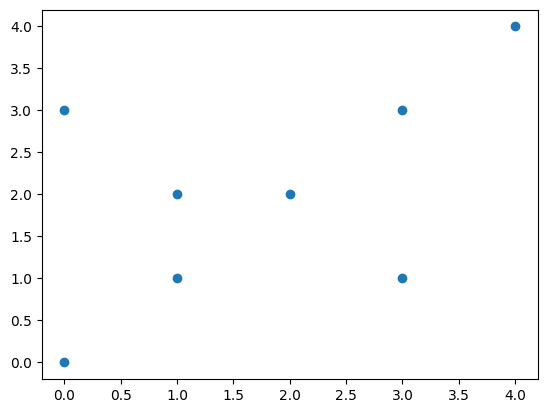

In [225]:
point_set = []

point_set.append(Point(0,3))
point_set.append(Point(0,0))
point_set.append(Point(1,1))
point_set.append(Point(2,2))
point_set.append(Point(3,3))
point_set.append(Point(4,4))
point_set.append(Point(3,1))
point_set.append(Point(1,2))

array_point_set = Tools.point_to_list(set=point_set)

plt.scatter(x=array_point_set[0],y=array_point_set[1])
plt.show()

Utilizando a função *find_convex_hull*, obtemos os pontos que fazem parte da envoltória, temos portanto:

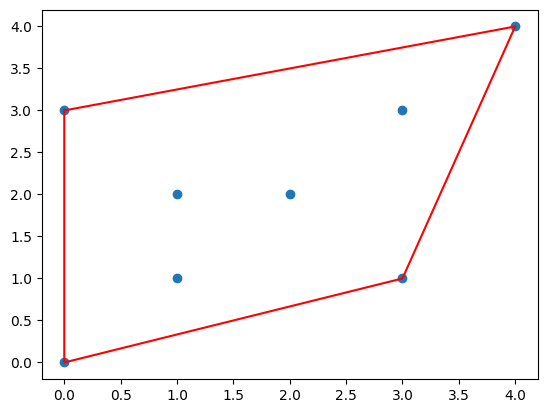

In [226]:
hull = ConvexHull(point_set)
hull.find_convex_hull()
hull_points = hull.hull
hull_points_array = Tools.point_to_list(set=hull_points)
hull_points_array[0].append(hull_points[0].x)
hull_points_array[1].append(hull_points[0].y)

plt.plot(hull_points_array[0],hull_points_array[1], color="red")
plt.scatter(x=array_point_set[0],y=array_point_set[1])
plt.show()

<p style="text-align: justify;">Vamos analisar agora um exemplo gerado aleatoriamente, representando uma envoltória de 50 pontos. É possivel gerar novos exemplos executando a célula abaixo novamente.</p>

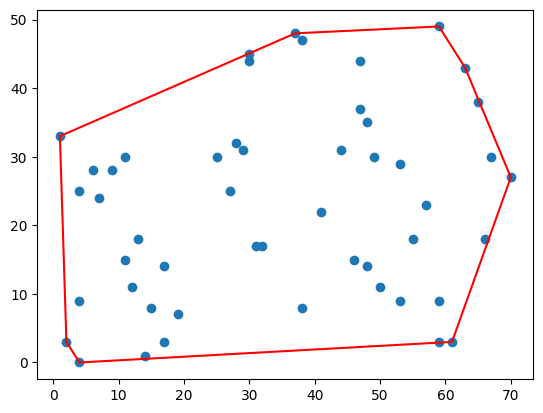

In [227]:
random_point_set = []
for x in range(0,50):
  random_point_set.append(Point(randint(0,70),randint(0,50)))

new_array_point_set = Tools.point_to_list(set=random_point_set)

plt.scatter(x=new_array_point_set[0],y=new_array_point_set[1])

new_hull = ConvexHull(random_point_set)
new_hull.find_convex_hull()
new_hull_points_array = Tools.point_to_list(set=new_hull.hull)
new_hull_points_array[0].append(new_hull.hull[0].x)
new_hull_points_array[1].append(new_hull.hull[0].y)

plt.plot(new_hull_points_array[0],new_hull_points_array[1], color="red")
plt.show()


## Separabilidade Linear

<p style="text-align: justify;">Agora, precisamos ter uma forma de testar se duas envoltórias se interceptam. Isso  é necessário, pois o algoritmo só funcionará caso as envoltórias não possuam interseção uma com a outra.</p>

In [228]:
class HullInterception:
    @classmethod
    def do_hulls_intercept(cls, hull_1: list[Point], hull_2: list[Point]):
        for p1, p2 in zip(hull_1, hull_1[1:]):
            smaller_1 = p1 if p1.x < p2.x else p2
            greater_1 = p1 if smaller_1 == p2 else p2

            for p3, p4 in zip(hull_2, hull_2[1:]):
                smaller_2 = p3 if p3.x < p4.x else p4
                greater_2 = p3 if smaller_2 == p4 else p4
                if Tools.do_segments_intercept(Segment(smaller_1, greater_1), Segment(smaller_2, greater_2)):
                    return True
            # Check last segment from 2nd hull
            if Tools.do_segments_intercept(Segment(smaller_1, greater_1), Segment(hull_2[0], hull_2[-1])):
                return True

        # Check last segment from 1st hull
        last_segment = Segment(hull_1[0], hull_1[-1])
        for p3, p4 in zip(hull_2, hull_2[1:]):
            smaller = p3 if p3.x < p4.x else p4
            greater = p3 if smaller == p4 else p4
            if Tools.do_segments_intercept(last_segment, Segment(smaller, greater)):
                return True

        # Check last segment from both
        if Tools.do_segments_intercept(last_segment, Segment(hull_2[0], hull_2[-1])):
            return True

        # Checking the possibility of a hull being inside the other
        for point in hull_1:
            if Tools.point_inside_hull(point, hull_2) == True: return True
        for point in hull_2:
            if Tools.point_inside_hull(point, hull_1) == True: return True

        return False        

## Ponto médio entre envoltórias

<p style="text-align: justify;">Com as envoltórias disponíveis e a certeza de que não há interseção entre elas, podemos partir para a criação do nosso modelo de classificação, utilizando um ponto médio entre os poligonos obtidos.<p>

In [229]:
INF = 0x3f3f3f3f

def find_closest_points(hull1: ConvexHull, hull2: ConvexHull):
    dist_min = INF
    closest = tuple((Point(0,0), Point(0,0)))
    for point1 in hull1.hull:
        for point2 in hull2.hull:
            dist_temp = Tools.get_point_distance(point1, point2)
            if dist_temp < dist_min:
                dist_min = dist_temp
                closest = tuple((point1, point2))
    return closest

def assign_hull(point: Point, hull1: ConvexHull, hull2: ConvexHull):
    point_hull1, point_hull2 = find_closest_points(hull1, hull2)

    if Tools.get_point_distance(point, point_hull1) < Tools.get_point_distance(point, point_hull2):
        return 1
    else:
        return 2

def get_x_range(hull1: ConvexHull, hull2: ConvexHull):
    min_x = INF
    max_x = -INF
    for point1 in hull1.hull:
      if point1.x < min_x:
        min_x = point1.x
      if point1.x > max_x:
        max_x = point1.x
    for point2 in hull2.hull:
      if point2.x < min_x:
        min_x = point2.x
      if point2.x > max_x:
        max_x = point2.x
    return min_x, max_x

def get_y_range(hull1: ConvexHull, hull2: ConvexHull):
    min_y = INF
    max_y = -INF
    for point1 in hull1.hull:
      if point1.y < min_y:
        min_y = point1.y
      if point1.y > max_y:
        max_y = point1.y
    for point2 in hull2.hull:
      if point2.y < min_y:
        min_y = point2.y
      if point2.y > max_y:
        max_y = point2.y
    return min_y, max_y

def separating_line_formula(x, hull1: ConvexHull, hull2: ConvexHull):
    point_hull1, point_hull2 = find_closest_points(hull1, hull2)

    linear_coefficient = (point_hull1.y - point_hull2.y) / (point_hull1.x - point_hull2.x)

    intercept = (point_hull1.y + point_hull2.y)/2 - ((-1/linear_coefficient) * (point_hull1.x + point_hull2.x)/2)

    return (-1 / linear_coefficient * x) + intercept

def plot_separating_line(hull1: ConvexHull, hull2: ConvexHull):
    point_hull1, point_hull2 = find_closest_points(hull1, hull2)

    half_point = Point((point_hull1.x + point_hull2.x)/2, (point_hull1.y + point_hull2.y)/2)
    min_x, max_x = get_x_range(hull1, hull2)
    min_y, max_y = get_y_range(hull1, hull2)

    while (abs(separating_line_formula(min_x, hull1, hull2)) - abs(half_point.y)) >= 1.5* abs((abs(min_y) - abs(half_point.y))):
      min_x += abs(min_x - half_point.x)/2
    while (abs(separating_line_formula(max_x, hull1, hull2)) - abs(half_point.y)) >= 1.5* (abs(max_y) - abs(half_point.y)):
      max_x -= abs(max_x - half_point.x)/2

    x = [min_x, max_x]
    y = [separating_line_formula(x[0], hull1, hull2), separating_line_formula(x[1], hull1, hull2)]

    plt.plot(x, y, color="green", linestyle='dashed')

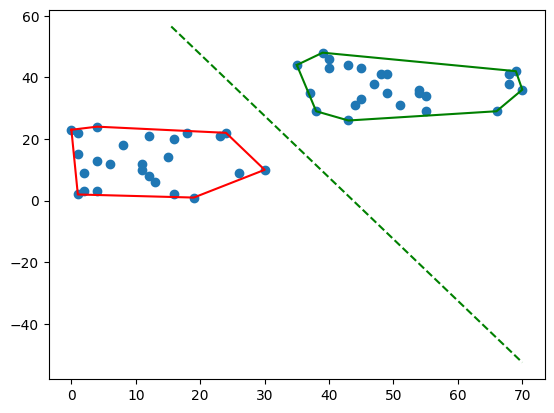

In [230]:
full_point_set = []

random_point_set1 = []
for x in range(0,25):
  point_temp = Point(randint(0,35),randint(0,25))
  random_point_set1.append(point_temp)
  full_point_set.append(point_temp)

new_array_point_set = Tools.point_to_list(set=random_point_set1)

random_point_set2 = []
for x in range(0,25):
  point_temp = Point(randint(35,70),randint(26,50))
  random_point_set2.append(point_temp)
  full_point_set.append(point_temp)

new_array_point_set_full = Tools.point_to_list(set=full_point_set)
new_array_point_set1 = Tools.point_to_list(set=random_point_set1)
new_array_point_set2 = Tools.point_to_list(set=random_point_set2)

plt.scatter(x=new_array_point_set_full[0],y=new_array_point_set_full[1])

new_hull1 = ConvexHull(random_point_set1)
new_hull1.find_convex_hull()
new_hull_points_array1 = Tools.point_to_list(set=new_hull1.hull)
new_hull_points_array1[0].append(new_hull1.hull[0].x)
new_hull_points_array1[1].append(new_hull1.hull[0].y)

new_hull2 = ConvexHull(random_point_set2)
new_hull2.find_convex_hull()
new_hull_points_array2 = Tools.point_to_list(set=new_hull2.hull)
new_hull_points_array2[0].append(new_hull2.hull[0].x)
new_hull_points_array2[1].append(new_hull2.hull[0].y)

plot_separating_line(new_hull1, new_hull2)
plt.plot(new_hull_points_array1[0],new_hull_points_array1[1], color="red")
plt.plot(new_hull_points_array2[0],new_hull_points_array2[1], color="green")
plt.show()


## Criação e análise de modelos

### Classes de tratamento
Antes de começar a análise de datasets, vamos criar algumas classes e funções que ajudam visualização dos dados e dos resultados obtidos.

In [231]:
class DataTraining:
    # Works with numpy arrays or Point arrays
    @classmethod
    def separate_dataset(cls, hull1: ConvexHull, hull2: ConvexHull):

        # Finding the center of the Convex Hulls
        hull1_x_mean = 0
        hull1_y_mean = 0
        for point in hull1.point_set:
            hull1_x_mean += (point.x)/len(hull1.point_set)
            hull1_y_mean += (point.y)/len(hull1.point_set)
        hull1_center = Point(hull1_x_mean, hull1_y_mean)

        hull2_x_mean = 0
        hull2_y_mean = 0
        for point in hull2.point_set:
            hull2_x_mean += (point.x)/len(hull2.point_set)
            hull2_y_mean += (point.y)/len(hull2.point_set)
        hull2_center = Point(hull2_x_mean, hull2_y_mean)

        # Copying points to a new set, ordered by distance to the opposing convex hull's center (descending)
        hull1_training_points = []
        training_points_count = int(len(hull1.point_set)*0.7)

        while (training_points_count > 0):
            point_temp = hull1.point_set[0]
            dist_temp = Tools.get_point_distance(point_temp, hull2_center)
            iter_temp = 0
            for iter in range(1, len(hull1.point_set)):
                if Tools.get_point_distance(hull1.point_set[iter], hull2_center) > dist_temp:
                    point_temp = hull1.point_set[iter]
                    dist_temp = Tools.get_point_distance(point_temp, hull2_center)
                    iter_temp = iter
            hull1_training_points.append(point_temp)
            hull1.point_set.pop(iter_temp)
            training_points_count -= 1
        
        # Remaining points are assigned to tests
        hull1_test_points = []
        for point in hull1.point_set:
            hull1_test_points.append(point)

        # Copying points to a new set, ordered by distance to the center (ascending)
        hull2_training_points = []
        training_points_count = int(len(hull2.point_set)*0.7)

        while (training_points_count > 0):
            point_temp = hull2.point_set[0]
            dist_temp = Tools.get_point_distance(point_temp, hull1_center)
            iter_temp = 0
            for iter in range(1, len(hull2.point_set)):
                if Tools.get_point_distance(hull2.point_set[iter], hull1_center) > dist_temp:
                    point_temp = hull2.point_set[iter]
                    dist_temp = Tools.get_point_distance(point_temp, hull1_center)
                    iter_temp = iter
            hull2_training_points.append(point_temp)
            hull2.point_set.pop(iter_temp)
            training_points_count -= 1

        hull2_test_points = []
        for point in hull2.point_set:
            hull2_test_points.append(point)

        return hull1_training_points, hull1_test_points, hull2_training_points, hull2_test_points

## Pipeline de Modelos ##

In [232]:
class GenerateModel:
    @classmethod
    def plot_model(self, class_set, point_color: str, test: bool, **kwargs):
        plt.scatter(class_set[:,0], class_set[:,1], color=point_color)

        if (not test):
            class_hull = kwargs.get("class_hull", ConvexHull)
            hull_color = kwargs.get("hull_color", str)
            class_hull_points_arr = Tools.point_to_list(class_hull)
            class_hull_points_arr[0].append(class_hull[0].x)
            class_hull_points_arr[1].append(class_hull[0].y)
            plt.plot(class_hull_points_arr[0], class_hull_points_arr[1], color=hull_color)

    @classmethod
    def gather_test_points(self, point_set):
        training_set = []
        test_set = []
        for point in point_set:
            if randint(1,10) <= 7:
                training_set.append(point)
            else:
                test_set.append(point)

        return (training_set, test_set)

    @classmethod
    def generate_by_datasets(self, dataset, class1_name: str, class2_name: str):        
        reduced_dataset = PCA(n_components=2).fit_transform(dataset.data)
        
        class_A = []
        class_B = []

        index = 0
        for x in dataset.target:
            if x == class1_name:
                class_A.append(tuple((reduced_dataset[index][0], reduced_dataset[index][1])))
            elif x == class2_name:
                class_B.append(tuple((reduced_dataset[index][0], reduced_dataset[index][1])))
            index += 1

        class_A = np.array(class_A)
        class_B = np.array(class_B)
        
        original_class_A_point_set = []
        original_class_B_point_set = []

        for point in class_A:
            original_class_A_point_set.append(Point(point[0], point[1]))
        for point in class_B:
            original_class_B_point_set.append(Point(point[0], point[1]))

        class_A_hull = ConvexHull(original_class_A_point_set)
        class_A_hull.find_convex_hull()
        class_B_hull = ConvexHull(original_class_B_point_set)
        class_B_hull.find_convex_hull()

        # Checking interception before DataTraining
        pre_interception = (HullInterception.do_hulls_intercept(class_A_hull.point_set, class_B_hull.point_set))
        if (not pre_interception):
            print("The convex hulls do not intercept")

            # pega 30% aleatório
            class_A_training, class_A_test = GenerateModel.gather_test_points(original_class_A_point_set)
            class_B_training, class_B_test = GenerateModel.gather_test_points(original_class_B_point_set)

            test_class_A = []
            for point in class_A_test:
                test_class_A.append([point.x, point.y])
            test_class_A = np.array(test_class_A)

            test_class_B = []
            for point in class_B_test:
                test_class_B.append([point.x, point.y])
            test_class_B = np.array(test_class_B)
                
            # Testing for hits and misses
            true_positives_b = 0
            true_positives_a = 0
            false_positives_a = 0
            false_positives_b = 0
            false_negatives_a = 0
            false_negatives_b = 0
            
            for point in class_A_test:
                result = (point in original_class_A_point_set) and (assign_hull(point, class_A_hull, class_B_hull) == 1)
                if result: true_positives_a += 1
                else: 
                    false_positives_a += 1
                    false_negatives_b += 1
            for point in class_B_test:
                result = (point in original_class_B_point_set) and (assign_hull(point, class_A_hull, class_B_hull) == 2)
                if result: true_positives_b += 1
                else:
                    false_positives_b += 1
                    false_negatives_a += 1
                    
            precision_a = true_positives_a/(true_positives_a+false_positives_a)
            recall_a = true_positives_a/(true_positives_a+false_negatives_a)
            precision_b = true_positives_b/(true_positives_b+false_positives_b)
            recall_b = true_positives_b/(true_positives_b+false_negatives_b)
            
            print(f"Hull 1 - Precision: {precision_a}, Recall: {recall_a}, F1-Score: {(2*precision_a*recall_a)/(precision_a+recall_a)}")
            print(f"Hull 2 - Precision: {precision_b}, Recall: {recall_b}, F1-Score: {(2*precision_b*recall_b)/(precision_b+recall_b)}")

            GenerateModel.plot_model(class_B, "royalblue", test=False, class_hull=class_B_hull.hull, hull_color="blue")
            GenerateModel.plot_model(class_A, "orangered", test=False, class_hull=class_A_hull.hull, hull_color="red")
            GenerateModel.plot_model(test_class_A, "yellow", test=True)
            GenerateModel.plot_model(test_class_B, "purple", test=True)
            plot_separating_line(class_A_hull, class_B_hull)

            # Plotting line between closest points
            point_hull1, point_hull2 = find_closest_points(class_A_hull, class_B_hull)        
            x = [point_hull1.x, point_hull2.x]
            y = [point_hull1.y, point_hull2.y]
            plt.plot(x, y, color="black")

        else: 
            # fazer a divisão dos 30% mais próximos
            class_A_training_set, class_A_test_set, class_B_training_set, class_B_test_set = DataTraining.separate_dataset(class_A_hull, class_B_hull)

            class_A = []
            for point in class_A_training_set:
                class_A.append([point.x, point.y])

            class_B = []
            for point in class_B_training_set:
                class_B.append([point.x, point.y])

            class_A = np.array(class_A)
            class_B = np.array(class_B)
            
            class_A_hull = ConvexHull(class_A_training_set)        
            class_A_hull.find_convex_hull()
            class_B_hull = ConvexHull(class_B_training_set)
            class_B_hull.find_convex_hull()

            testing_class_A = []
            for point in class_A_test_set:
                testing_class_A.append([point.x, point.y])
            testing_class_A = np.array(testing_class_A)       

            testing_class_B = []
            for point in class_A_test_set:
                testing_class_B.append([point.x, point.y])
            testing_class_B = np.array(testing_class_B)       

            # Checking interception after DataTraining
            post_interception = (HullInterception.do_hulls_intercept(class_A_hull.hull, class_B_hull.hull))

            GenerateModel.plot_model(testing_class_A, "purple", test=True)
            GenerateModel.plot_model(testing_class_B, "purple", test=True)
            GenerateModel.plot_model(class_B, "royalblue", test=False, class_hull=class_B_hull.hull, hull_color="blue")
            GenerateModel.plot_model(class_A, "orangered", test=False, class_hull=class_A_hull.hull, hull_color="red")
            
            # Plotting line between closest points
            point_hull1, point_hull2 = find_closest_points(class_A_hull, class_B_hull)        
            x = [point_hull1.x, point_hull2.x]
            y = [point_hull1.y, point_hull2.y]
            plt.plot(x, y, color="black")

            if (not post_interception): 
                print("The convex hulls intercept, but we may use 30 percent of points as test data")
                plot_separating_line(class_A_hull, class_B_hull)
                
                # Testing for hits and misses
                true_positives_b = 0
                true_positives_a = 0
                false_positives_a = 0
                false_positives_b = 0
                false_negatives_a = 0
                false_negatives_b = 0
                
                for point in class_A_test_set:
                    result = (point in original_class_A_point_set) and (assign_hull(point, class_A_hull, class_B_hull) == 1)
                    if result: true_positives_a += 1
                    else: 
                        false_positives_a += 1
                        false_negatives_b += 1
                for point in class_B_test_set:
                    result = (point in original_class_B_point_set) and (assign_hull(point, class_A_hull, class_B_hull) == 2)
                    if result: true_positives_b += 1
                    else:
                        false_positives_b += 1
                        false_negatives_a += 1
                        
                precision_a = true_positives_a/(true_positives_a+false_positives_a)
                recall_a = true_positives_a/(true_positives_a+false_negatives_a)
                precision_b = true_positives_b/(true_positives_b+false_positives_b)
                recall_b = true_positives_b/(true_positives_b+false_negatives_b)
                
                print(f"Hull 1 - Precision: {precision_a}, Recall: {recall_a}, F1-Score: {(2*precision_a*recall_a)/(precision_a+recall_a)}")
                print(f"Hull 2 - Precision: {precision_b}, Recall: {recall_b}, F1-Score: {(2*precision_b*recall_b)/(precision_b+recall_b)}")

            elif (post_interception):
                print("The convex hulls intercept too strongly to apply a model")

        plt.show()

    @classmethod
    def generate_by_csv(self, csv_file: str, class_column: str, class1_name: str, class2_name: str):
        dataset = pd.read_csv(csv_file)
        dataset_classes_column = dataset[class_column]
        dataset.drop(columns=class_column, inplace=True)
        
        reduced_dataset = PCA(n_components=2).fit_transform(dataset)
        
        class_A = []
        class_B = []

        index = 0
        for x in dataset_classes_column:
            if x == class1_name:
                class_A.append(reduced_dataset[index])
            elif x == class2_name:
                class_B.append(reduced_dataset[index])
            index += 1

        class_A = np.array(class_A)
        class_B = np.array(class_B)
        
        original_class_A_point_set = []
        original_class_B_point_set = []

        for point in class_A:
            original_class_A_point_set.append(Point(point[0], point[1]))
        for point in class_B:
            original_class_B_point_set.append(Point(point[0], point[1]))

        class_A_hull = ConvexHull(original_class_A_point_set)
        class_A_hull.find_convex_hull()
        class_B_hull = ConvexHull(original_class_B_point_set)
        class_B_hull.find_convex_hull()

        # Checking interception before DataTraining
        pre_interception = (HullInterception.do_hulls_intercept(class_A_hull.point_set, class_B_hull.point_set))
        if (not pre_interception):
            print("The convex hulls do not intercept")

            class_A_training, class_A_test = GenerateModel.gather_test_points(original_class_A_point_set)
            class_B_training, class_B_test = GenerateModel.gather_test_points(original_class_B_point_set)

            test_class_A = []
            for point in class_A_test:
                test_class_A.append([point.x, point.y])
            test_class_A = np.array(test_class_A)

            test_class_B = []
            for point in class_B_test:
                test_class_B.append([point.x, point.y])
            test_class_B = np.array(test_class_B)

            # Testing for hits and misses
            true_positives_b = 0
            true_positives_a = 0
            false_positives_a = 0
            false_positives_b = 0
            false_negatives_a = 0
            false_negatives_b = 0
            
            for point in class_A_test:
                result = (point in original_class_A_point_set) and (assign_hull(point, class_A_hull, class_B_hull) == 1)
                if result: true_positives_a += 1
                else: 
                    false_positives_a += 1
                    false_negatives_b += 1
            for point in class_B_test:
                result = (point in original_class_B_point_set) and (assign_hull(point, class_A_hull, class_B_hull) == 2)
                if result: true_positives_b += 1
                else:
                    false_positives_b += 1
                    false_negatives_a += 1
                    
            precision_a = true_positives_a/(true_positives_a+false_positives_a)
            recall_a = true_positives_a/(true_positives_a+false_negatives_a)
            precision_b = true_positives_b/(true_positives_b+false_positives_b)
            recall_b = true_positives_b/(true_positives_b+false_negatives_b)
            
            print(f"Hull 1 - Precision: {precision_a}, Recall: {recall_a}, F1-Score: {(2*precision_a*recall_a)/(precision_a+recall_a)}")
            print(f"Hull 2 - Precision: {precision_b}, Recall: {recall_b}, F1-Score: {(2*precision_b*recall_b)/(precision_b+recall_b)}")

            GenerateModel.plot_model(class_B, "royalblue", test=False, class_hull=class_B_hull.hull, hull_color="blue")
            GenerateModel.plot_model(class_A, "orangered", test=False, class_hull=class_A_hull.hull, hull_color="red")
            GenerateModel.plot_model(test_class_A, "yellow", test=True)
            GenerateModel.plot_model(test_class_B, "purple", test=True)
            plot_separating_line(class_A_hull, class_B_hull)

            # Plotting line between closest points
            point_hull1, point_hull2 = find_closest_points(class_A_hull, class_B_hull)        
            x = [point_hull1.x, point_hull2.x]
            y = [point_hull1.y, point_hull2.y]
            plt.plot(x, y, color="black")

            #print(f"Hits: {hits*100/(len(class_A_test) + len(class_B_test))}%, Misses: {misses*100/(len(class_A_test) + len(class_B_test))}%")
        else: 
            class_A_point_set, class_A_test_set, class_B_point_set, class_B_test_set = DataTraining.separate_dataset(class_A_hull, class_B_hull)

            class_A = []
            for point in class_A_point_set:
                class_A.append([point.x, point.y])

            class_B = []
            for point in class_B_point_set:
                class_B.append([point.x, point.y])

            class_A = np.array(class_A)
            class_B = np.array(class_B)
            
            class_A_hull = ConvexHull(class_A_point_set)        
            class_A_hull.find_convex_hull()
            class_B_hull = ConvexHull(class_B_point_set)
            class_B_hull.find_convex_hull()

            testing_class_A = []
            for point in class_A_test_set:
                testing_class_A.append([point.x, point.y])
            testing_class_A = np.array(testing_class_A)       

            testing_class_B = []
            for point in class_A_test_set:
                testing_class_B.append([point.x, point.y])
            testing_class_B = np.array(testing_class_B)       

            # Checking interception after DataTraining
            post_interception = (HullInterception.do_hulls_intercept(class_A_hull.hull, class_B_hull.hull))

            GenerateModel.plot_model(testing_class_A, "purple", test=True)
            GenerateModel.plot_model(testing_class_B, "purple", test=True)
            GenerateModel.plot_model(class_B, "royalblue", test=False, class_hull=class_B_hull.hull, hull_color="blue")
            GenerateModel.plot_model(class_A, "orangered", test=False, class_hull=class_A_hull.hull, hull_color="red")
            
            # Plotting line between closest points
            point_hull1, point_hull2 = find_closest_points(class_A_hull, class_B_hull)        
            x = [point_hull1.x, point_hull2.x]
            y = [point_hull1.y, point_hull2.y]
            plt.plot(x, y, color="black")

            if (not post_interception): 
                print("The convex hulls intercept, but we may use 30 percent of points as test data")
                plot_separating_line(class_A_hull, class_B_hull)
                
                # Testing for hits and misses
                true_positives_a = 0
                true_positives_b = 0
                false_positives_a = 0
                false_positives_b = 0
                false_negatives_a = 0
                false_negatives_b = 0
                
                for point in class_A_test_set:
                    result = (point in original_class_A_point_set) and (assign_hull(point, class_A_hull, class_B_hull) == 1)
                    if result: true_positives_a += 1
                    else: 
                        false_positives_a += 1
                        false_negatives_b += 1
                        
                for point in class_B_test_set:
                    result = (point in original_class_B_point_set) and (assign_hull(point, class_A_hull, class_B_hull) == 2)
                    if result: true_positives_b += 1
                    else:
                        false_positives_b += 1
                        false_negatives_a += 1
                    
                precision_a = true_positives_a/(true_positives_a+false_positives_a)
                recall_a = true_positives_a/(true_positives_a+false_negatives_a)
                precision_b = true_positives_b/(true_positives_b+false_positives_b)
                recall_b = true_positives_b/(true_positives_b+false_negatives_b)
                
                print(f"Hull 1 - Precision: {precision_a}, Recall: {recall_a}, F1-Score: {(2*precision_a*recall_a)/(precision_a+recall_a)}")
                print(f"Hull 2 - Precision: {precision_b}, Recall: {recall_b}, F1-Score: {(2*precision_b*recall_b)/(precision_b+recall_b)}")

            elif (post_interception):
                print("The convex hulls intercept too strongly to apply a model")

        plt.show()  

## Teste 1: Iris ##

The convex hulls do not intercept
Hull 1 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Hull 2 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0


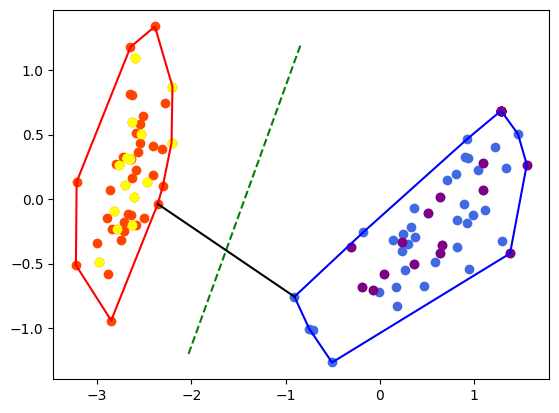

In [233]:
iris = datasets.load_iris()
GenerateModel.generate_by_datasets(iris, 0, 1)

## Teste 2: Câncer de Mama ##

The convex hulls intercept, but we may use 30 percent of points as test data
Hull 1 - Precision: 0.453125, Recall: 0.5370370370370371, F1-Score: 0.4915254237288136
Hull 2 - Precision: 0.7685185185185185, Recall: 0.7033898305084746, F1-Score: 0.7345132743362832


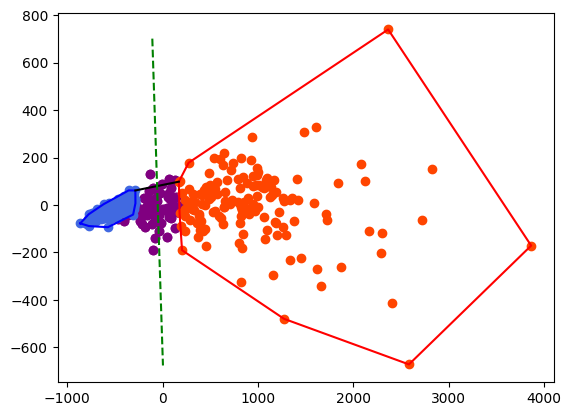

In [234]:
breast_cancer = datasets.load_breast_cancer()
GenerateModel.generate_by_datasets(breast_cancer, 0, 1)

## Teste 3: Banana ## 

The convex hulls intercept too strongly to apply a model


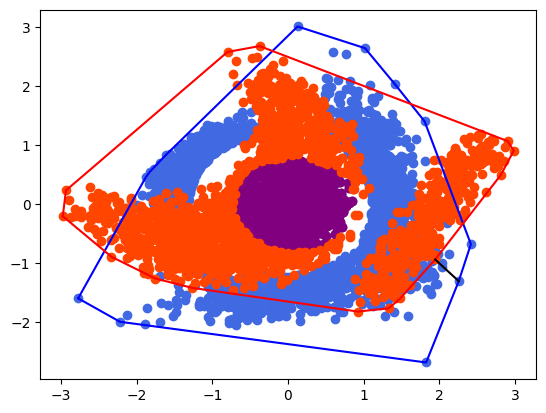

In [235]:
GenerateModel.generate_by_csv("datasets/banana_prepared.csv", "Class", 1.0, -1.0)

## Teste 4: Segmentos ##

The convex hulls do not intercept
Hull 1 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Hull 2 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0


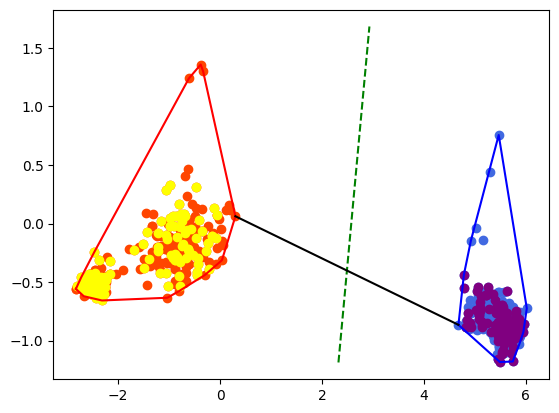

In [236]:
GenerateModel.generate_by_csv("datasets/segments.csv", "Class", 1, 2)

## Teste 5: Cogumelos ##

The convex hulls intercept too strongly to apply a model


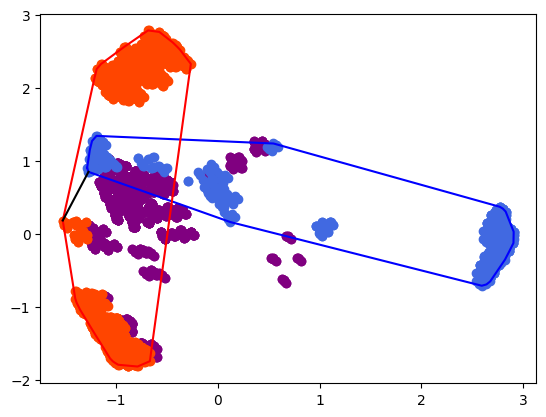

In [237]:
GenerateModel.generate_by_csv("datasets/mushroom.csv", "Class", 'e', 'p')

## Teste 6: Thyroid ##

The convex hulls do not intercept
Hull 1 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Hull 2 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0


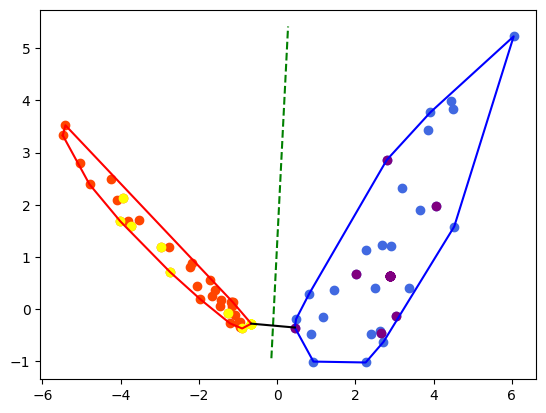

In [238]:
GenerateModel.generate_by_csv("datasets/newthyroid.prepared.csv", "Class", 2, 3)

## Teste 7: Glass ##

The convex hulls intercept, but we may use 30 percent of points as test data
Hull 1 - Precision: 0.9523809523809523, Recall: 0.9090909090909091, F1-Score: 0.9302325581395349
Hull 2 - Precision: 0.5, Recall: 0.6666666666666666, F1-Score: 0.5714285714285715


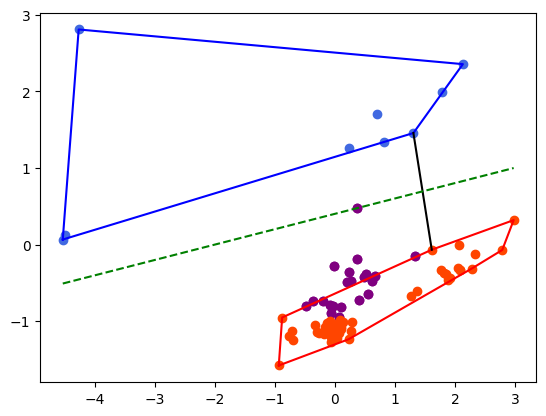

In [239]:
GenerateModel.generate_by_csv("datasets/glass.prepared.csv", "TypeGlass", 1, 5)

## Teste 8: Zoo ##

The convex hulls do not intercept
Hull 1 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Hull 2 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0


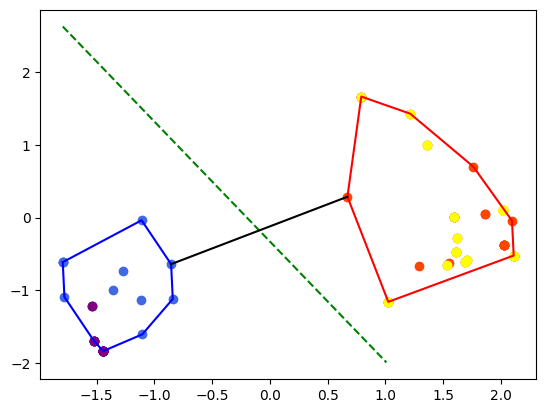

In [240]:
GenerateModel.generate_by_csv("datasets/zoo.csv", "Type", 1, 2)

## Teste 9: Wine ##

The convex hulls intercept, but we may use 30 percent of points as test data
Hull 1 - Precision: 1.0, Recall: 0.8181818181818182, F1-Score: 0.9
Hull 2 - Precision: 0.8181818181818182, Recall: 1.0, F1-Score: 0.9


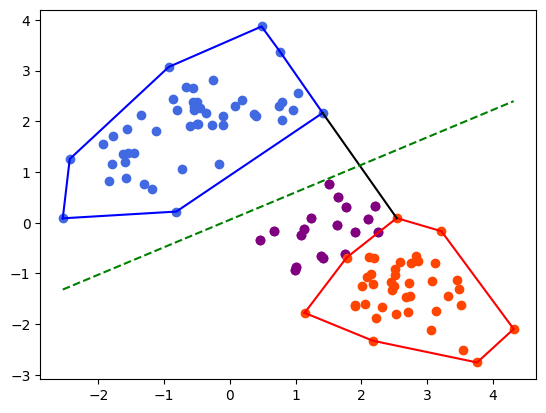

In [241]:
GenerateModel.generate_by_csv("datasets/wine.csv", "Class", 1, 2)

## Teste 10: Falantes de Alemão ##

The convex hulls intercept too strongly to apply a model


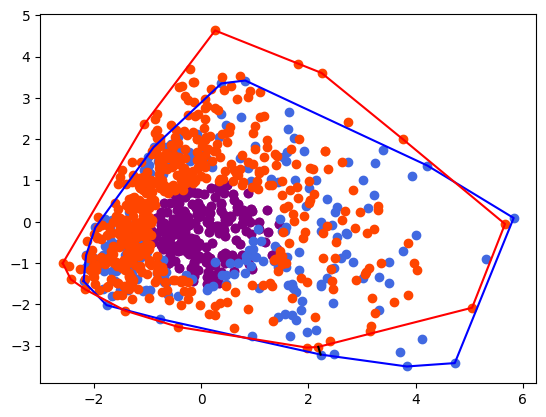

In [242]:
GenerateModel.generate_by_csv("datasets/german.prepared.csv", "Customer", 1, 2)

## Conclusão: ##
Nesse trabalho, executamos diversos algoritmos e técnicas vistas em sala para implementar um classificador. Primeiramente, lemos os dados através de    arquivos csv ou de dados do Scikit Learn. Então, usamos um PCA para reduzi-los a duas dimensões, e dividí-los todos em duas classes. Dessa forma, podemos calcular as envoltórias convexas das classes A e B, e verificar se há interseção entre elas.

Caso não haja interseção, temos um caso mais simples: os 30% dos pontos de teste são selecionados aleatoriamente, e, como as classes são bem separadas, temos um modelo com 100% de aproveitamento em Precisão, Revocação e F1-Score (como visto nos casos teste 1, 4, 6 e 8).

Caso haja interseção, tentamos selecionar os pontos de teste de forma mais esperta: pegamos pontos das duas envoltórias que estão o mais próximo possível do centro da outra envoltória. Assim, há a possibilidade de que o grupo dos 70% dos pontos restantes não se intercepte. Isso ocorreu nos casos 2, 7 e 9. No caso 2, tivemos um desempenho mediano do modelo, com 61% de aproveitamento, e resultados piores na envoltória número 1. No caso 7, a envoltória 1 teve 93% de aproveitamento, enquanto a segunda teve apenas 57%. Isso ocorre pois claramente os pontos da segunda envoltória eram menos compactados. Finalmente, tivemos sucesso no caso 9, em que nosso modelo performou em 90% em ambas as envoltórias.

Entretanto, é possível que nossa seleção dos pontos teste não surte efeito, e que de fato as duas classes se interceptam de forma não separável. Foi o caso 3, 5, e 10, o que impede nosso modelo de funcionar.